In [21]:
# !pip install palettable
# !pip install paddlets
# !pip install ray
# !pip install optuna

In [22]:
# %matplotlib inline
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei']
# import seaborn as sns
# import palettable
# import paddle
# from tqdm import tqdm
# from pandas.tseries.frequencies import to_offset
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import datetime
# import paddlets
# from paddlets import TSDataset
# from paddlets import TimeSeries
# from paddlets.models.forecasting import MLPRegressor, LSTNetRegressor
# from paddlets.transform import Fill, StandardScaler
# from paddlets.metrics import MSE, MAE
# from paddlets.analysis import AnalysisReport, Summary
# from paddlets.datasets.repository import get_dataset

# import random
# seed = 42
# # 设置随机数
# paddle.seed(seed)
# np.random.seed(seed)
# random.seed(seed)

# import warnings
# warnings.filterwarnings('ignore')

# 1 数据分析
本赛题数据集由全球最大风电运营企业龙源电力提供，采集自真实风力发电数据。 预选赛训练数据和区域赛训练数据分别为不同10个风电场近一年的运行数据共30万余条，每15分钟采集一次，包括风速、风向、温度、湿度、气压和真实功率等，具体的数据字段中英文对应如下：

* WINDSPEED 预测风速
* WINDDIRECTION 风向
* TEMPERATURE 温度
* HUMIDITY 湿度
* PRESSURE 气压
* PREPOWER 预测功率（系统生成）
* ROUND(A.WS,1) 实际风速
* ROUND(A.POWER,0) 实际功率（计量口径一）
* YD15 实际功率（预测目标，计量口径二）
![](https://ai-studio-static-online.cdn.bcebos.com/407246b2a71d4a32936a4eb9b2a7e9ac2b850d2820ad422596299663b5a7f0bc)


In [23]:
# def data_preprocess(data_dir):
#     """数据预处理
#     Ref: https://aistudio.baidu.com/bj-cpu-01/user/397884/5913446/lab/workspaces/auto-d
#     """
#     files = os.listdir(data_dir)
#     # 第一步，完成数据格式统一
#     for f in files:
#         # 获取文件路径
#         data_file = os.path.join(data_dir, f)
#         # 获取文件名后缀
#         data_type = os.path.splitext(data_file)[-1]
#         # 获取文件名前缀
#         data_name = os.path.splitext(data_file)[0]
#         # 如果是excel文件，进行转换
#         if data_type == '.xlsx':
#             # 需要特别注意的是，在读取excel文件时要指定空值的显示方式，否则会在保存时以字符“.”代替，影响后续的数据分析
#             data_xls = pd.read_excel(data_file, index_col=0, na_values='')
#             data_xls.to_csv(data_name + '.csv', encoding='utf-8')
#             # 顺便删除原文件
#             os.remove(data_file)
#     # 第二步，完成多文件的合并，文件目录要重新更新一次
#     files = os.listdir(data_dir)
#     for f in files:
#         # 获取文件路径
#         data_file = os.path.join(data_dir, f)
#         # 获取文件名前缀
#         data_basename = os.path.basename(data_file)
#         # 检查风机数据是否有多个数据文件
#         if len(data_basename.split('-')) > 1:
#             merge_list = []
#             # 找出该风机的所有数据文件
#             matches = [ f for f in files if (f.find(data_basename.split('-')[0] + '-') > -1)]
#             for i in matches:
#                 # 读取风机这部分数据
#                 data_df = pd.read_csv(os.path.join(data_dir, i), index_col=False, keep_default_na=False)
#                 merge_list.append(data_df)
#             if len(merge_list) > 0:
#                 all_data = pd.concat(merge_list,axis=0,ignore_index=True).fillna(".")
#                 all_data.to_csv(os.path.join(data_dir, data_basename.split('-')[0]+ '.csv'),index=False) 
#             for i in matches:
#                 # 删除这部分数据文件
#                 os.remove(os.path.join(data_dir, i))
#             # 更新文件目录
#             files = os.listdir(data_dir)

In [24]:
# data_preprocess('功率预测竞赛赛题与数据集')

In [25]:
# 数据读取
wind_id = '13'
df = pd.read_csv(f'区域赛训练集/{wind_id}.csv',parse_dates=['DATATIME'],infer_datetime_format=True,dayfirst=True,
                dtype={'WINDDIRECTION':np.float64, 'HUMIDITY':np.float64, 'PRESSURE':np.float64})
df = df.sort_values(by='DATATIME', ascending=True)
# df1 = pd.read_csv(f'区域赛训练集/{wind_id}.csv',parse_dates=['DATATIME'],infer_datetime_format=True,dayfirst=True,
#                 dtype={'WINDDIRECTION':np.float64, 'HUMIDITY':np.float64, 'PRESSURE':np.float64})
# df2 = pd.read_csv(f'Data/{wind_id}.csv',parse_dates=['DATATIME'],infer_datetime_format=True,dayfirst=True,
#                 dtype={'WINDDIRECTION':np.float64, 'HUMIDITY':np.float64, 'PRESSURE':np.float64})
# df1 = df1.sort_values(by='DATATIME', ascending=True)
# df2 = df2.sort_values(by='DATATIME', ascending=True)
print('df.shape:', df.shape)
print(f"Time range: {df['DATATIME'].values[0]} -- {df['DATATIME'].values[-1]}")

df.shape: (64562, 10)
Time range: 2021-04-02T00:00:00.000000000 -- 2022-04-30T23:45:00.000000000


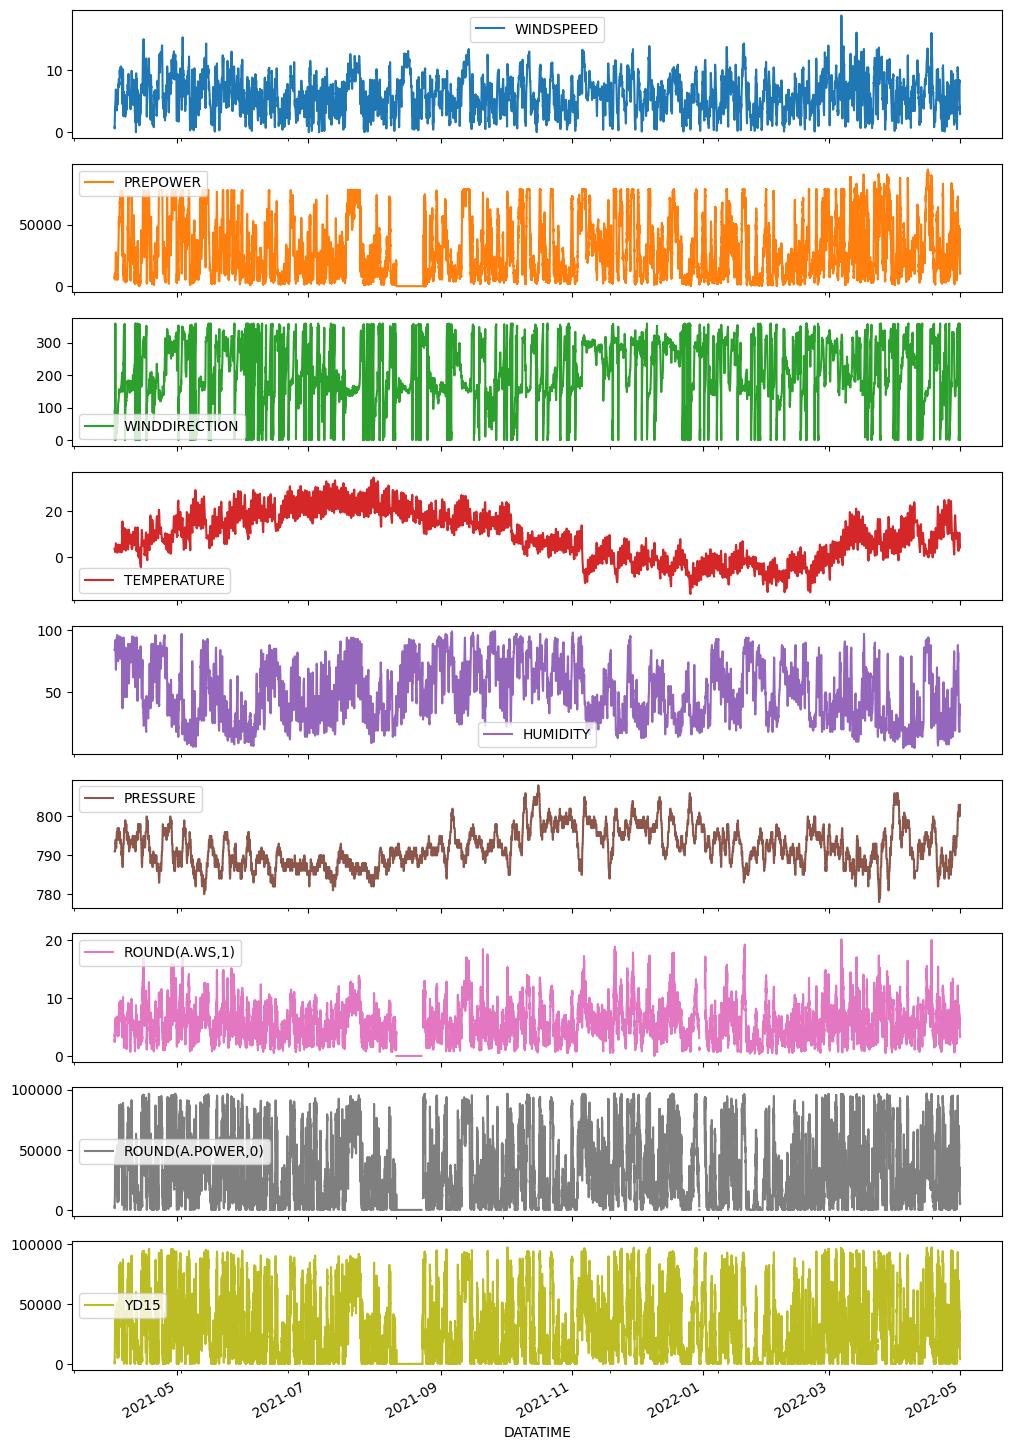

In [26]:
# 绘制各列特征的时序图
df.plot(x='DATATIME', y=df.columns[1:], subplots=True, figsize=(12,20))
plt.show()

In [27]:
# # 绘制各列特征的时序图
# df2.plot(x='DATATIME', y=df2.columns[1:], subplots=True, figsize=(12,20))
# plt.show()

In [28]:
# df.info()

In [29]:
# df.head()
# df.tail()
df.describe()

,WINDSPEED,PREPOWER,WINDDIRECTION,TEMPERATURE,HUMIDITY,PRESSURE,"ROUND(A.WS,1)","ROUND(A.POWER,0)",YD15
count,64562.000000,64562.000000,64562.000000,64562.000000,64562.000000,64562.000000,63789.000000,63789.000000,63886.000000
mean,6.019112,29201.630362,214.942660,7.667424,50.290310,792.555172,5.727047,30578.626785,28854.949535
std,2.922486,24963.793766,87.329798,10.796861,23.581178,4.911837,3.134577,29397.071317,28617.756616
min,0.000000,0.000000,0.000000,-16.100000,5.000000,778.000000,0.000000,-24.000000,0.000000
25%,3.740000,7866.000000,157.000000,-1.500000,30.000000,789.000000,3.400000,4683.000000,3622.000000
50%,5.830000,21452.200000,214.000000,6.900000,48.000000,792.000000,5.400000,20868.000000,18956.500000
75%,8.100000,46559.800000,293.000000,16.400000,69.000000,796.000000,7.600000,51713.000000,48754.000000
max,18.810000,94624.000000,359.000000,34.800000,99.000000,808.000000,20.200000,96991.000000,97382.000000


In [30]:
# 因为数据批次不同，数据集中有一些时间戳重复的脏数据，送入paddlets前要进行处理，本赛题要求保留第一个数据
df.drop_duplicates(subset = ['DATATIME'],keep='first',inplace=True)

# 我们选取最后30天的风机工况数据进行可视化
target_cov_dataset = TSDataset.load_from_dataframe(
    df,
    time_col='DATATIME',
    target_cols=['ROUND(A.POWER,0)', 'YD15'],
    observed_cov_cols=['WINDSPEED', 'PREPOWER', 'WINDDIRECTION', 'TEMPERATURE',
       'HUMIDITY', 'PRESSURE', 'ROUND(A.WS,1)'],
    freq='15min',
    fill_missing_dates=False
)

# 由于不同指标的数值差异较大，在绘图时选取数值范围相近的组合分开绘制可视化图表
# target_cov_dataset.plot(['WINDSPEED', 'TEMPERATURE', 'ROUND(A.WS,1)'])
target_cov_dataset.summary()

,"ROUND(A.POWER,0)",YD15,WINDSPEED,PREPOWER,WINDDIRECTION,TEMPERATURE,HUMIDITY,PRESSURE,"ROUND(A.WS,1)"
missing,0.014065,0.013695,0.002538,0.002538,0.002538,0.002538,0.002538,0.002538,0.014065
count,37292.000000,37306.000000,37728.000000,37728.000000,37728.000000,37728.000000,37728.000000,37728.000000,37292.000000
mean,30402.539794,28630.101003,6.034950,28282.699592,213.986482,9.046692,49.906780,792.117313,5.637284
std,29441.864048,28630.613306,2.922543,24849.113556,87.866766,10.878586,23.743693,4.917968,3.133108
min,-24.000000,0.000000,0.000000,0.000000,0.000000,-16.100000,5.000000,778.000000,0.000000
25%,4408.250000,3357.750000,3.800000,7155.818485,156.000000,0.000000,30.000000,788.000000,3.300000
50%,20599.500000,18693.000000,5.830000,20426.140000,211.000000,8.900000,48.000000,792.000000,5.300000
75%,51512.250000,48460.000000,8.100000,45134.880000,293.000000,17.900000,69.000000,796.000000,7.500000
max,96991.000000,97382.000000,18.810000,94591.000000,359.000000,34.800000,99.000000,808.000000,20.200000


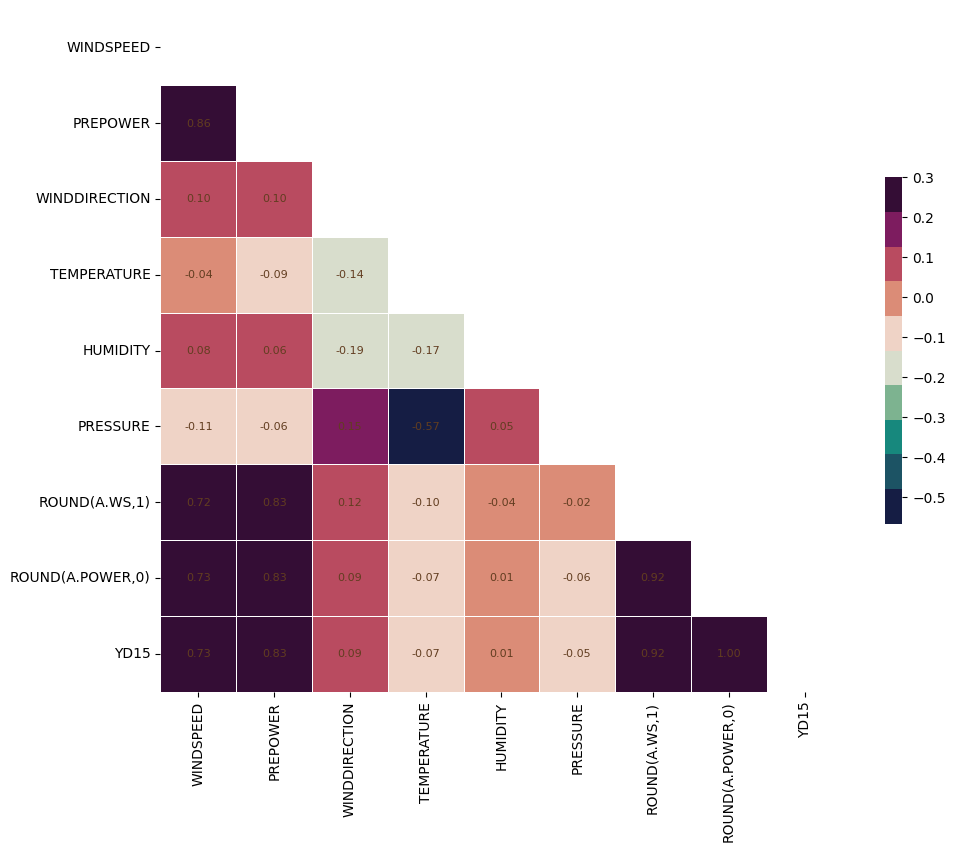

In [31]:
# corr函数计算相关性矩阵(correlation matrix)
df_corr = df.corr(method='pearson')
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data=df_corr,
            vmax=0.3, 
            cmap=palettable.cmocean.diverging.Curl_10.mpl_colors,
            annot=True,
            fmt=".2f",
            annot_kws={'size':8, 'weight':'normal', 'color':'#623D20'},
            mask=np.triu(np.ones_like(df_corr,dtype=np.bool)),#显示对脚线下面部分图
            square=True, linewidths=.5,#每个方格外框显示，外框宽度设置
            cbar_kws={"shrink": .5}
           )
plt.show()

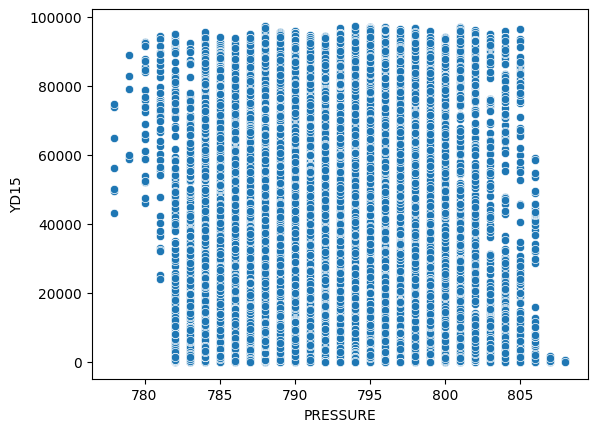

In [32]:
sns.scatterplot(x='PRESSURE', y='YD15', data=df)
plt.show()

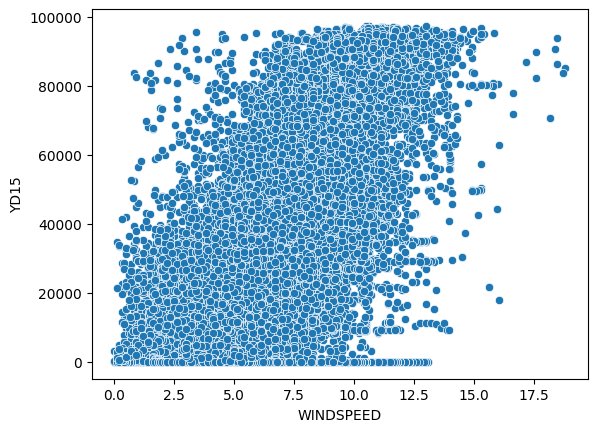

In [33]:
sns.scatterplot(x='WINDSPEED', y='YD15', data=df)
plt.show()

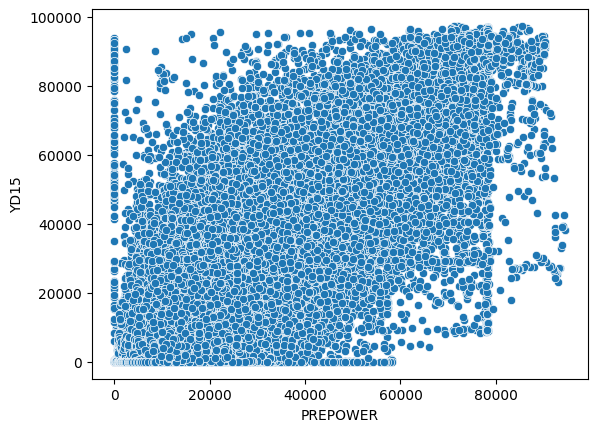

In [34]:
sns.scatterplot(x='PREPOWER', y='YD15', data=df)
plt.show()

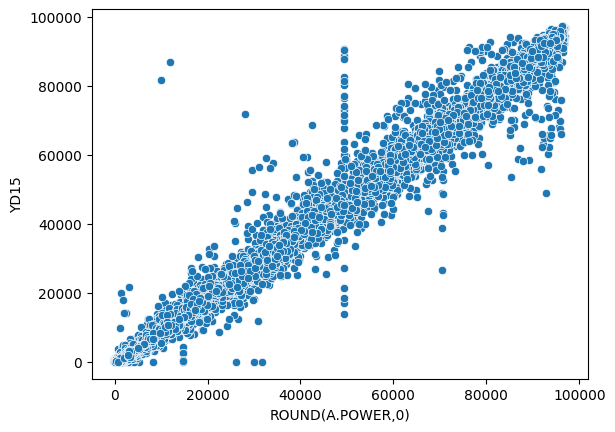

In [35]:
sns.scatterplot(x='ROUND(A.POWER,0)', y='YD15', data=df)
plt.show()

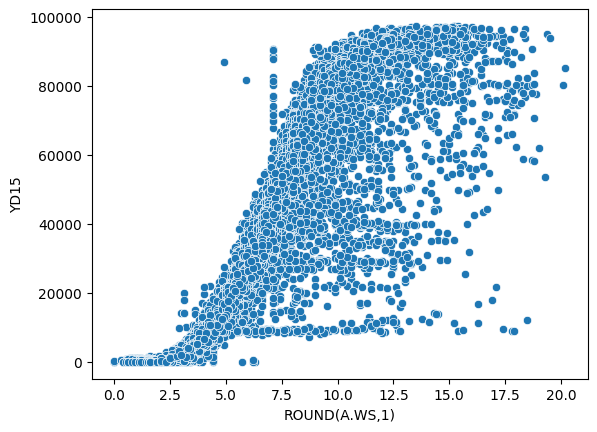

In [36]:
# 查看实际风速和实际功率(预测目标，计量口径二)的相关图
sns.scatterplot(x='ROUND(A.WS,1)', y='YD15', data=df)
plt.show()

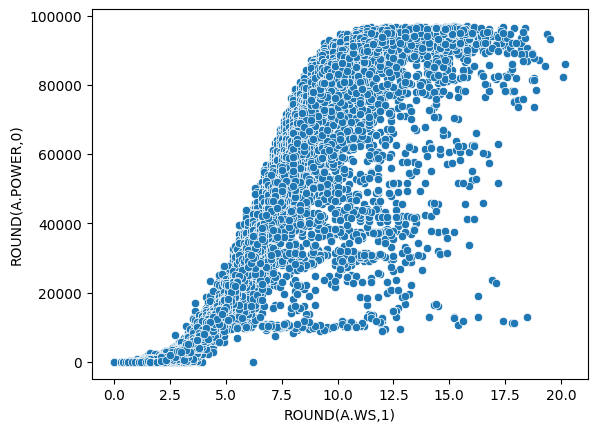

In [37]:
# 查看实际风速和实际功率(计量口径一)的的相关图
sns.scatterplot(x='ROUND(A.WS,1)', y='ROUND(A.POWER,0)', data=df)
plt.show()

官方回复：
- 由于测量设备和网络传输问题，YD15可能出现数据异常（包括用于评测的输入数据）。
- 实际上由于一些脏数据的存在，YD15有时候会缺失或异常，这个时候round（A，power0）如果有正常值的话，可以被视为YD15的替代。
- YD15的异常值处理规则是，当YD15为空时，按照逻辑依次用ROUND(A.POWER,0)、PREPOWER 进行替换。
- 如何定义YD15存在异常？ 在本赛题中，YD15异常包括两种情况：(1)空值，(2)在一段时间内、其它字段正常变化时，YD15持续完全不变。除以上两种情况之外，YD15的数值变化都可认为是正常现象，如为0或负值。

个人补充：
- 当实际风速为0时，存在功率>0有些异常，然后有些风速过大>12.5，存在功率为0的异常。

* 目标列ROUND(A.POWER,0和YD15，与风速WINDSPEED、PREPOWER、PRESSURE和ROUND(A.WS,1)强相关；
* 目标列ROUND(A.POWER,0和YD15之间就有很强的相关性；

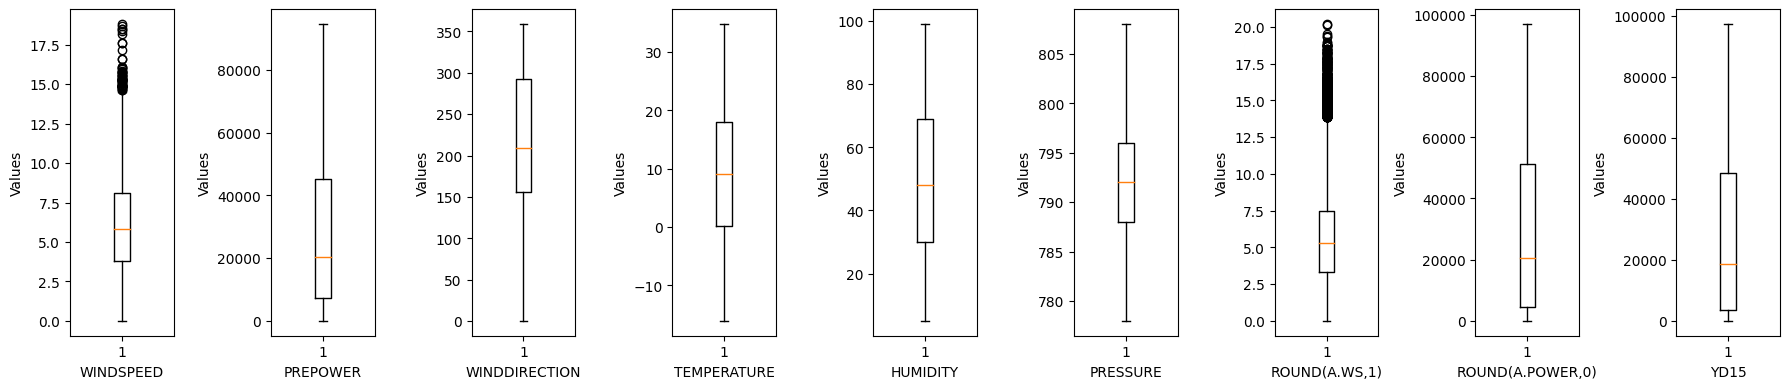

In [38]:
# 从具体数值上，观察异常样本情况
# 绘制箱须图
def boxplot(data, cont_var_names):
    '''只对连续性变量画箱须图'''
    var_num = len(cont_var_names)
    fig = plt.figure(figsize = (2*var_num, 4))
    for i in range(var_num):
        plt.subplot(1,var_num,i+1)
        x = [data[i] for i in contvar_names]
        plt.boxplot(data[cont_var_names[i]]) 
        plt.xlabel(cont_var_names[i])
        plt.ylabel("Values")
    plt.tight_layout()
    plt.show()

contvar_names = df.columns[1:] # 这里地方除掉了时间戳这个变量
boxplot(df.dropna(), contvar_names)

In [39]:
def cal_miss_info(data):
    """缺失值统计"""
    miss_count = data.isnull().sum().sort_values(ascending=False)
    miss_pert = miss_count / len(data)
    miss_info = pd.concat([miss_count, miss_pert], axis=1, keys=["缺失计数", "缺失百分比"])
    print(miss_info)

cal_miss_info(df)

                  缺失计数     缺失百分比
ROUND(A.POWER,0)   436  0.011556
ROUND(A.WS,1)      436  0.011556
YD15               422  0.011185
PRESSURE             0  0.000000
HUMIDITY             0  0.000000
TEMPERATURE          0  0.000000
WINDDIRECTION        0  0.000000
PREPOWER             0  0.000000
WINDSPEED            0  0.000000
DATATIME             0  0.000000


In [40]:
def duplicate_det(data, subset):
    """重复值检测"""
    if data.duplicated(subset=subset).any() != True:
        print("无重复无样本")
    else:
        print("有重复样本")
        dup_samp_num = len(data[data.duplicated(subset=subset)])
        print(f"重复样本数量: {dup_samp_num}, 占比: {dup_samp_num/len(data)*100}%")

duplicate_det(df, 'DATATIME')

无重复无样本
